In [32]:
import functools as ft

import pandas as pd
import numpy as np
import scipy.stats as ss
import swifter
from gvs_ab import gvs_ab as ab

import pandahouse

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Задача 1

Коллеги из ML отдела предложили новый алгоритм:
- добавляет пользователям 1-2 просмотра
- вероятность работоспособности 90%
- если у пользователя меньше 50 просмотров, то алгоритм не сработает

Увеличится ли при этом количество лайков на пользователя? Надо Монте-Карлить!

План
- Есть данные по AA-тестам за '2024-02-23'-'2024-02-29'
- Выгрузить данные по пользователям, полагая что по ним можно моделировать актуальное поведение пользователей
- Сымитируем эффект алгоритма на просмотры: 
    - group_B_views + ((1 + np.binomial(n=1, p=0.5, size=размер_выборки)) * np.binomial(n=1, p=0.9, size=размер_выборки) * (group_B_views >= 50))
    - views + (1 + Binomial(n, 0.5)) * (1 + Binomial(n, 0.9)) * (views >= 50)
- Проведём 20к симуляций, используя t-тест
- Уровень значимости 0.05.

# Калькулятор размера выборки

Необходимый размер выборки

$$n > \frac{\left[ \Phi^{-1} \left( 1-\alpha /2 \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

- $\varepsilon$ - размер эффекта, 
- $\alpha$ - вероятность ошибки первого рода, 
- $\beta$ - вероятность ошибки 2 рода

=> необходимо задать требуемые: $\varepsilon$, $\alpha$, $\beta$

Пусть ищем отличия в CTR с удовлетворяющими параметрами:
- $\varepsilon = 0.01$ п.п.
- $\alpha = 0.05$
- $\beta = 0.2$

## Расчёт размеров выборки

In [33]:
# Подключение к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}
# db='simulator_20240320'
db='simulator'

In [34]:
# date_start = "toDate('2024-03-01')"
# date_end = "toDate('2024-03-07')"
date_start = "toDate('2021-11-08')"
date_end = "toDate('2021-11-14')"


q = f"""
WITH 
filtered_data AS (
    SELECT
        user_id,
        time,
        exp_group,
        action
    FROM {db}.feed_actions
    WHERE 
        time>={date_start} AND time<{date_end}+1
),
feed_actions AS (
    -- Активность пользователей из интересующих групп за указанный период
    SELECT
        toDate(time) AS date,
        user_id,
        exp_group,
        countIf(time, action='like') AS likes,
        countIf(time, action='view') AS views
    FROM filtered_data
    GROUP BY date, user_id, exp_group
)

SELECT *
FROM feed_actions
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df

,date,user_id,exp_group,likes,views
0,2021-11-10,15845,0,7,33
1,2021-11-10,122615,1,11,40
2,2021-11-09,13119,4,4,31
3,2021-11-12,18558,3,7,30
4,2021-11-08,1668,2,4,48
...,...,...,...,...,...
85564,2021-11-13,21034,4,10,35
85565,2021-11-10,116989,0,11,53
85566,2021-11-11,116040,1,3,16
85567,2021-11-13,118335,2,6,18


In [35]:
# Подневный CTR
date_info = df.groupby('date', as_index=False)[['views', 'likes']].sum()
date_info['ctr'] = date_info.likes / date_info.views
date_info.head()

,date,views,likes,ctr
0,2021-11-08,395721,80252,0.202799
1,2021-11-09,399625,81114,0.202975
2,2021-11-10,450062,93330,0.207371
3,2021-11-11,442453,91942,0.207801
4,2021-11-12,476835,105195,0.220611


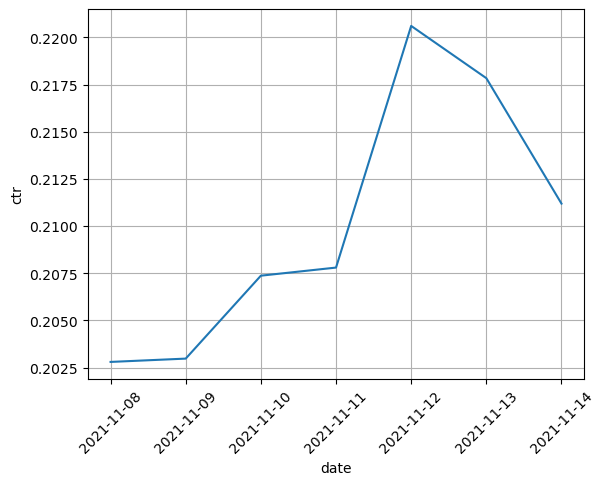

In [36]:
sns.lineplot(date_info, x='date', y='ctr');
plt.xticks(rotation=45)
plt.grid();

In [37]:
date_info.ctr.describe()

count    7.000000
mean     0.210084
std      0.006933
min      0.202799
25%      0.205173
50%      0.207801
75%      0.214517
max      0.220611
Name: ctr, dtype: float64

In [38]:
# Поюзерный CTR
user_info = df.groupby('user_id', as_index=False)[['views', 'likes']].sum()
user_info['ctr'] = user_info.likes / user_info.views
user_info.head()

,user_id,views,likes,ctr
0,200,36,12,0.333333
1,202,16,3,0.187500
2,203,14,7,0.500000
3,204,38,8,0.210526
4,206,11,2,0.181818


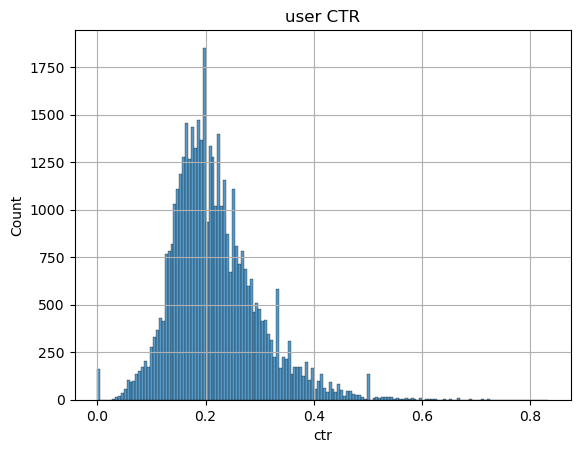

In [39]:
sns.histplot(user_info.ctr);
plt.title('user CTR')
plt.grid()

In [40]:
user_info.ctr.describe()

count    42585.000000
mean         0.218015
std          0.081250
min          0.000000
25%          0.164179
50%          0.205479
75%          0.259259
max          0.833333
Name: ctr, dtype: float64

In [41]:
# std поюзерного CTR 
# (тк пытаемся найти необходимое количество юзеров)
std = user_info.ctr.std()
std

0.08125006748054106

In [42]:
# Требуемый размер выборки
sample_size = ab.get_ttest_sample_size(0.01, std, std)
sample_size

1037

## Проверка формулы. Синтетические тесты

Научимся моделировать распределения просмотров, CTR, лайков для юзеров

In [43]:
# Количество пользователей
n_users = user_info.shape[0]
n_users

42585

*user views distribution*

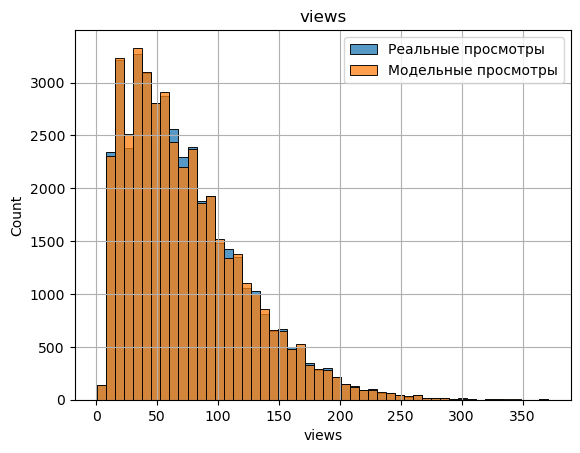

In [44]:
# Модель распределения просмотров

# Гистограмма
views_discrete_hist = user_info.views.value_counts(normalize=True)

# Модель дискретного распределения
views_distr = ss.rv_discrete(values=
    (views_discrete_hist.index, views_discrete_hist.values)
)

# Проверка
bins=50
sns.histplot(
    user_info.views,
    bins=bins,
    label='Реальные просмотры'
);
sns.histplot(
    views_distr.rvs(size=n_users),
    bins=bins,
    label='Модельные просмотры'
);
plt.title('views');
plt.legend()
plt.grid();

*user CTR distribution*

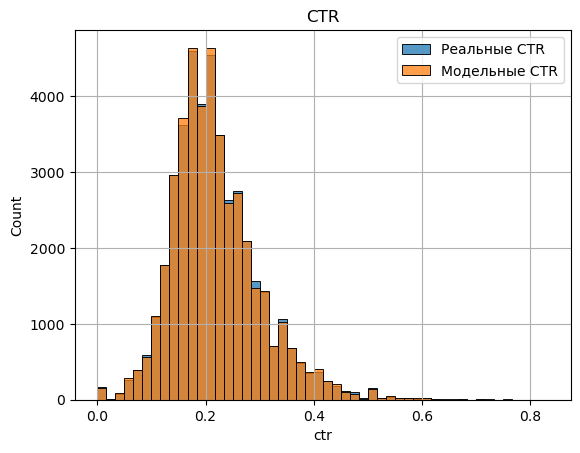

In [45]:
# Модель распределения ctr

# Гистограмма
ctr_discrete_hist = user_info.ctr.value_counts(normalize=True)

# Модель дискретного распределения
ctr_distr = ss.rv_discrete(values=
    (ctr_discrete_hist.index, ctr_discrete_hist.values)
)

# Проверка
bins=50
sns.histplot(
    user_info.ctr,
    bins=bins,
    label='Реальные CTR'
);
sns.histplot(
    ctr_distr.rvs(size=n_users),
    bins=bins,
    label='Модельные CTR'
);
plt.title('CTR');
plt.legend()
plt.grid();

*user likes distribution*

Получается из комбинации распределений просмотров и CTR

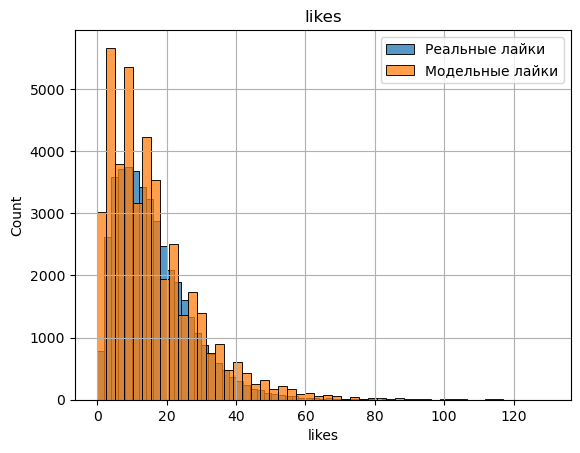

In [46]:
views_model = views_distr.rvs(size=n_users).astype('int32')
ctr_model = ctr_distr.rvs(size=n_users)

likes_model = ss.binom.rvs(views_model, ctr_model)

# Проверка
bins=50
sns.histplot(
    user_info.likes,
    bins=bins,
    label='Реальные лайки'
);
sns.histplot(
    likes_model,
    bins=bins,
    label='Модельные лайки'
);
plt.title('likes');
plt.legend()
plt.grid();

Интересно, что модель даёт завышенные результаты, но форма распределений схожая. Основное, что нас интересует - CTR а он идентичен реальному

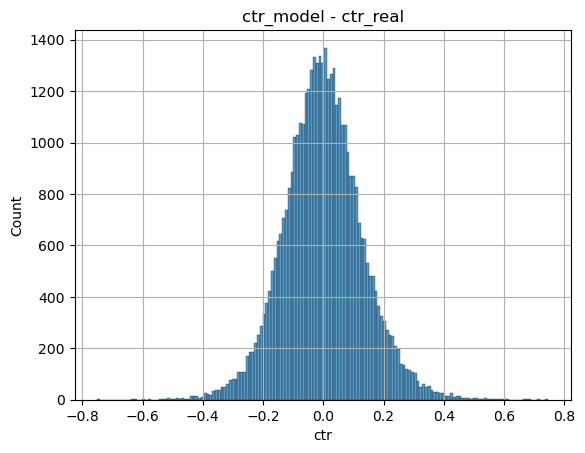

In [47]:
sns.histplot(likes_model/views_model - user_info.ctr);
plt.title('ctr_model - ctr_real');
plt.grid();

### Синтетический A/A тест

In [48]:
# Классы для генерирования правдоподобных данных

class Group:
    '''Контрольная/тестовая группа'''
    def __init__(
        self, 
        n_simulations, sample_size,  # Размеры
        views_distr, ctr_distr,  # Распределения
        ctr_mul  # Множитель для изменения CTR
):
        self.n_simulations = n_simulations
        self.sample_size = sample_size
        self.views_distr = views_distr
        self.ctr_distr = ctr_distr
        self.ctr_mul = ctr_mul
        
        self.views = None
        self.ctr = None
        self.likes = None
        
        self.create()
        
    def create(self):
        #  Не нужно ли сдвигать распределение, а не наблюдения непосредственно?
        self.views = self.views_distr.rvs(size=(self.n_simulations, self.sample_size)).astype('int32')
        self.ctr_model = self.ctr_distr.rvs(size=(self.n_simulations, self.sample_size)) * self.ctr_mul
        self.likes = ss.binom.rvs(self.views, self.ctr_model)
        self.ctr = self.likes / self.views
        

class DataSimulator:
    '''Источник симулированных данных'''
    def __init__(
        self, 
        n_simulations, sample_size,  # Размеры
        views_distr, ctr_distr,  # Распределения
        ctr_mul  # Множитель для изменения CTR    
):
        self.__n_simulations = n_simulations
        self.__sample_size = sample_size
        self.__views_distr = views_distr
        self.__ctr_distr = ctr_distr
        self.__ctr_mul = ctr_mul
        
        self.a = Group(
            self.__n_simulations,
            self.__sample_size,
            self.__views_distr,
            self.__ctr_distr,
            1
        )  # Контрольная группа
        
        self.b = Group(
            self.__n_simulations,
            self.__sample_size,
            self.__views_distr,
            self.__ctr_distr,
            self.__ctr_mul
        )  # Тестовая группа

In [49]:
sample_size  # Расчётный размер выборки

1037

In [64]:
n_simulations = 2000  # Количество синтетических экспериментов
alpha = 0.05  # Уровень значимости

# Генерируем данные для выборок
sim = DataSimulator(
    n_simulations, sample_size,
    views_distr, ctr_distr,
    1
)

# Статтесты
pvals = ab.func_for_mtx_rows(ss.ttest_ind, sim.a.ctr, sim.b.ctr, res_idx=1)

fpr = sum(pvals < alpha) / n_simulations
fpr

0.0475

FPR удовлетворительный (совпадает с тем, что был заложен при проектировании)

### Синтетический A/B тест

In [51]:
# Во сколько раз необходимо изменить ctr для желаемого размера эффекта
eps = 0.01  # Желаемый размер эффекта

cur_ctr = user_info.ctr.mean()
wish_ctr = cur_ctr + eps
k = wish_ctr / cur_ctr
k

1.04586845241024

In [52]:
sample_size

1037

In [53]:
# Генерируем данные для выборок
sim = DataSimulator(
    n_simulations, sample_size,
    views_distr, ctr_distr,
    k
)

# Статтесты
pvals = ab.func_for_mtx_rows(ss.ttest_ind, sim.a.ctr, sim.b.ctr, res_idx=1)

fnr = 1 - sum(pvals < alpha) / n_simulations
fnr

0.4205

Значение получается завышенное (в силу дополнительного шума, который мы вносим дополнительной случайностью моделирования - случайное сэмплирование для просмотров и ctr + лайки из биномиального распределения)

In [54]:
# Реальное значение
std

0.08125006748054106

In [55]:
# Модельное значение контрольной группы
std_a = sim.a.ctr.std()
std_a

0.1019105664802527

In [56]:
# Модельное значение тестовой группы
std_b = sim.b.ctr.std()
std_b

0.1054140654380304

=> модельные условия более жёсткие. При правильном дизайне эксперимента заявленные требования будут обеспечены с запасом

Увеличим размер выборки

In [57]:
ab.get_ttest_sample_size(0.01, std_a, std_b)

1688

In [65]:
sample_size = 1700

# Генерируем данные для выборок
sim = DataSimulator(
    n_simulations, sample_size,
    views_distr, ctr_distr,
    k
)

# Статтесты
pvals = ab.func_for_mtx_rows(ss.ttest_ind, sim.a.ctr, sim.b.ctr, res_idx=1)

fnr = 1 - sum(pvals < alpha) / n_simulations
fnr

0.18999999999999995

Бинго. Теперь все требования выполняются!

Как при этом соотносится теория (fnr по формуле) с практикой (модельное fnr)?

In [59]:
def get_formula_fnr(sample_size, eps, std_1, std_2, alpha=0.05):
    fnr = 1 - ss.norm.cdf(
        eps * np.sqrt(sample_size / (std_1**2 + std_2**2))
        - ss.norm.ppf(1 - alpha/2)
    )
    return fnr

In [60]:
# Как соотносится теория с практикой
mde = 0.01  # Детектируемое изменение CTR в п.п.
n_simulations = 1000  # Количество симуляций
sample_sizes = np.arange(800, 2001, 100)  # Размер выборки
fnrs_model = []  # Данные из моделирований
fnrs_formula_for_model = []  # Применение формулы для std, которые получаются при моделировании
fnrs_formula = []  # Применение формулы для std реальных данных

for sample_size in tqdm(sample_sizes):
    # Генерируем данные для выборок
    sim = DataSimulator(
        n_simulations, sample_size,
        views_distr, ctr_distr,
        k
    )
    
    # Модель
    pvals = ab.func_for_mtx_rows(ss.ttest_ind, sim.a.ctr, sim.b.ctr, res_idx=1)
    fnr = 1 - sum(pvals < alpha) / n_simulations
    fnrs_model.append(fnr)
    
    # Формула для модели
    fnr = get_formula_fnr(sample_size, mde, sim.a.ctr.std(), sim.b.ctr.std())
    fnrs_formula_for_model.append(fnr)
    
    # Формула для реальных данных
    fnr = get_formula_fnr(sample_size, mde, std, std*k)
    fnrs_formula.append(fnr)

fnrs_model = np.asarray(fnrs_model)
fnrs_formula_for_model = np.asarray(fnrs_formula_for_model)
fnrs_formula = np.asarray(fnrs_formula)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:25<00:00,  6.61s/it]


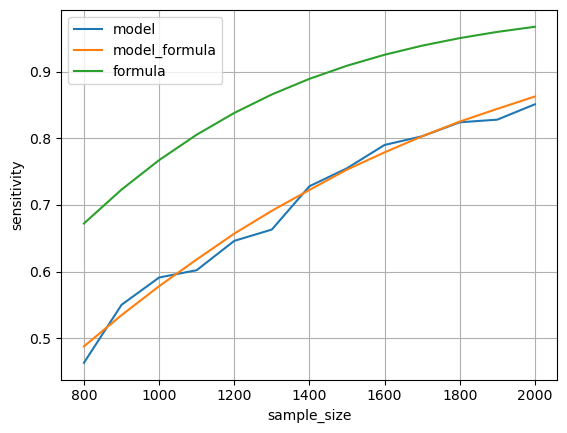

In [61]:
sns.lineplot(x=sample_sizes, y=1-fnrs_model, label='model');
sns.lineplot(x=sample_sizes, y=1-fnrs_formula_for_model, label='model_formula');
sns.lineplot(x=sample_sizes, y=1-fnrs_formula, label='formula');
plt.ylabel('sensitivity');
plt.xlabel('sample_size');
plt.grid()
plt.legend();

#### Выводы:
- формула для расчёта размера выборки работает крайне точно, если правильно задать std
- если задать std исходных данных, то произойдёт ощутимая потеря точности формулы

### Что с чувствительностью других тестов?

In [62]:
def bucket_ctr_test(likes_a, views_a, likes_b, views_b, buckets=100, test=ss.ttest_ind):
    a = pd.DataFrame({'likes': likes_a, 'views': views_a})
    b = pd.DataFrame({'likes': likes_b, 'views': views_b})
    
    a = ab.bucketization(a, 
                         column=None, buckets=buckets, print_info=False)
    b = ab.bucketization(b, 
                         column=None, buckets=buckets, print_info=False)
    
    a = a.groupby('bucket', as_index=False)[['likes', 'views']].sum()
    a['ctr'] = a.likes / a.views
    b = b.groupby('bucket', as_index=False)[['likes', 'views']].sum()
    b['ctr'] = b.likes / b.views
    
    return test(a.ctr, b.ctr)

In [75]:
mde = 0.01  # Детектируемое изменение CTR в п.п.
n_simulations = 1000  # Количество симуляций
sample_sizes = np.arange(800, 2001, 100)  # Размер выборки
fnrs_t = []
fnrs_u = []
fnrs_bucket = []
fnrs_lin = []

for sample_size in tqdm(sample_sizes):
    # Генерируем данные для выборок
    sim = DataSimulator(
        n_simulations, sample_size,
        views_distr, ctr_distr,
        k
    )
    
    # t-test
    pvals = ab.func_for_mtx_rows(ss.ttest_ind, sim.a.ctr, sim.b.ctr, res_idx=1)
    fnr = 1 - sum(pvals < alpha) / n_simulations
    fnrs_t.append(fnr)
    
    # U-test
    pvals = ab.func_for_mtx_rows(ss.mannwhitneyu, sim.a.ctr, sim.b.ctr, res_idx=1)
    fnr = 1 - sum(pvals < alpha) / n_simulations
    fnrs_u.append(fnr)
    
    # buckets + t-test
    pvals = ab.func_for_mtx_rows(
        bucket_ctr_test, 
        sim.a.likes, sim.a.views, 
        sim.b.likes, sim.b.views, 
        res_idx=1
    )
    fnr = 1 - sum(pvals < alpha) / n_simulations
    fnrs_bucket.append(fnr)
    
    # linearization + t-test
    linearized_likes = ab.func_for_mtx_rows(
        ab.linearization_ratio,
        sim.a.likes, sim.a.views, 
        sim.b.likes, sim.b.views
    )
    pvals = np.array([ss.ttest_ind(a,b)[1] for a, b in linearized_likes])
    fnr = 1 - sum(pvals < alpha) / n_simulations
    fnrs_lin.append(fnr)
    


fnrs_t = np.asarray(fnrs_t)
fnrs_u = np.asarray(fnrs_u)
fnrs_bucket = np.asarray(fnrs_bucket)
fnrs_lin = np.asarray(fnrs_lin)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:51<00:00, 13.20s/it]


In [77]:
n_simulations = 100  # Количество симуляций
fnrs_bootstrap = []

sample_sizes = np.arange(800, 2001, 100)  # Размер выборки

for sample_size in tqdm(sample_sizes):
    # Генерируем данные для выборок
    sim = DataSimulator(
        n_simulations, sample_size,
        views_distr, ctr_distr,
        k
    )

    # bootstrap
    pvals = ab.func_for_mtx_rows(
        ft.partial(ab.poisson_bootstrap_ctr, print_info=False),
        sim.a.likes, sim.a.views, 
        sim.b.likes, sim.b.views,
        res_idx=0
    )
    fnr = 1 - sum(pvals < alpha) / n_simulations
    fnrs_bootstrap.append(fnr)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [11:31<00:00, 53.21s/it]


In [78]:
fnrs_bootstrap = np.asarray(fnrs_bootstrap)

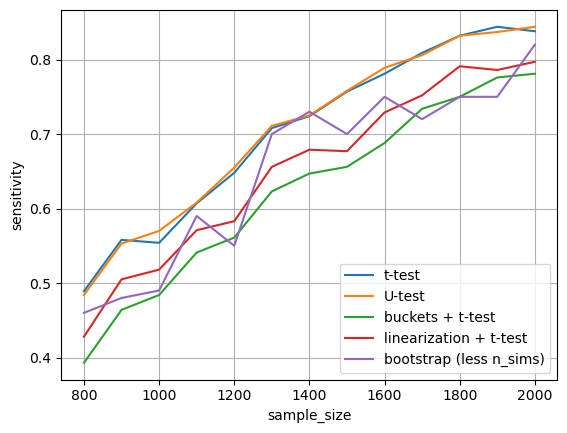

In [82]:
sns.lineplot(x=sample_sizes, y=1-fnrs_t, label='t-test');
sns.lineplot(x=sample_sizes, y=1-fnrs_u, label='U-test');
sns.lineplot(x=sample_sizes, y=1-fnrs_bucket, label='buckets + t-test');
sns.lineplot(x=sample_sizes, y=1-fnrs_lin, label='linearization + t-test');
sns.lineplot(x=sample_sizes, y=1-fnrs_bootstrap, label='bootstrap (less n_sims)');
plt.ylabel('sensitivity');
plt.xlabel('sample_size');
plt.grid()
plt.legend();

# Бакетное преобразование

In [ ]:
def bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    """
    Разбиваем на бакеты с весами
    :param ctrs_0: np.array shape (n_experiments, n_users), CTRs of every user from control group in every experiment
    :param weights_0: np.array (n_experiments, n_users), веса пользователей в контрольной группе
    :param ctrs_1: np.array (n_experiments, n_users), CTRs of every user from treatment group in every experiment
    :param weights_1: np.array (n_experiments, n_users), веса пользователей в целевой группе
    :param n_buckets: int, кол-во бакетов
    :return: np.array shape (n_experiments), средневзвешенные метрики в каждом бакете
    """

    n_experiments, n_users = ctrs_0.shape

    values_0 = np.zeros((n_experiments, n_buckets))
    values_1 = np.zeros((n_experiments, n_buckets))

    for b in np.arange(n_buckets):
        ind = np.arange(b * n_users / n_buckets, b * n_users / n_buckets + n_users / n_buckets).astype(np.int32)
        values_0[:, b] = np.sum(ctrs_0[:, ind] * weights_0[:, ind], axis=1) / np.sum(weights_0[:, ind], axis=1)
        values_1[:, b] = np.sum(ctrs_1[:, ind] * weights_1[:, ind], axis=1) / np.sum(weights_1[:, ind], axis=1)

    return values_0, values_1

In [ ]:
# t-тест поверх бакетов
def t_test_buckets(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    return t_test(*bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets))

# тест Манна-Уитни поверх бакетов
def mannwhitney_buckets(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    return mannwhitney(*bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets))

In [ ]:
p_values_ab = mannwhitney_buckets(
        clicks_A/group_A_views, group_A_views,
        clicks_B/group_B_views, group_B_views)

In [ ]:
np.sum(p_values_ab<= 0.05)/2000

# Линеаризация

In [ ]:
group_A_views = views_distr.rvs(size = (2000, 2000)).astype("int32")
group_B_views = views_distr.rvs(size = (2000, 2000)).astype("int32")
group_A_ctr = get_ctrs(2000, 2000, distrib, values)*1.05
group_B_ctr = get_ctrs(2000, 2000, distrib, values)
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

In [ ]:
control_ctr = stats.binom.rvs(group_B_views, group_B_ctr).sum(axis = 1)/group_B_views.sum(axis = 1)

In [ ]:
linearized_A = clicks_A - (group_A_views.T*control_ctr).T
linearized_B = clicks_B - (group_B_views.T*control_ctr).T

In [ ]:
linearization_p_values = t_test(linearized_A, linearized_B)

In [ ]:
sum(linearization_p_values<=0.05)/2000

# А на самом деле просмотры обычно выглядят не так...

In [ ]:
mu = 1
sigma2 = 1.5
N = 1447
experiments = 1000
views_lognormal = np.absolute(np.exp(norm(mu, sigma2).rvs(
    experiments * N)).astype(np.int64).reshape(experiments, N) + 1)

In [ ]:
fig = plt.figure()
ax_views = fig.add_subplot()
views_distr = sns.histplot(views_lognormal.ravel(),  # Теперь это массив длины experiments * N
                           bins=range(0, 30),
                           kde=False,
                           ax=ax_views,
                           stat='probability')
ax_views.set_xlim((0, 30))
views_99_percentile = np.percentile(views_lognormal.ravel(), 99)
ax_views.set_title(f'Views, 99%-ile = {views_99_percentile:<7.1f}')

In [ ]:
def get_views(experiments, N, mu = 1, sigma = 1.5):
    views_lognormal = np.absolute(
        np.exp(
            norm(mu, 
                 sigma2).rvs(experiments * N)
        ).astype(np.int64).reshape(experiments, N) + 1)
    return views_lognormal

In [ ]:
group_A_views = get_views(2000, 11000).astype("int32")
group_B_views = get_views(2000, 11000).astype("int32")
group_A_ctr = get_ctrs(2000, 11000, distrib, values)*1.05
group_B_ctr = get_ctrs(2000, 11000, distrib, values)
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

In [ ]:
compute_sample_size_abs(0.01, 0.278, 0.278)

In [ ]:
(clicks_B/group_B_views).std(axis = 1)[0]

In [ ]:
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

In [ ]:
np.sum(t_test_buckets(clicks_A/group_A_views, 
                      group_A_views,
                      clicks_B/group_B_views, 
                      group_B_views)<= 0.05)/2000

# А если я хочу сдвинуть медиану ...

In [ ]:
def bucketization_median(ctrs_0, ctrs_1, n_buckets=100):
    """
    Разбиваем на бакеты с весами
    :param ctrs_0: np.array shape (n_experiments, n_users), CTRs of every user from control group in every experiment
    :param weights_0: np.array (n_experiments, n_users), веса пользователей в контрольной группе
    :param ctrs_1: np.array (n_experiments, n_users), CTRs of every user from treatment group in every experiment
    :param weights_1: np.array (n_experiments, n_users), веса пользователей в целевой группе
    :param n_buckets: int, кол-во бакетов
    :return: np.array shape (n_experiments), средневзвешенные метрики в каждом бакете
    """

    n_experiments, n_users = ctrs_0.shape

    values_0 = np.zeros((n_experiments, n_buckets))
    values_1 = np.zeros((n_experiments, n_buckets))

    for b in np.arange(n_buckets):
        ind = np.arange(b * n_users / n_buckets, b * n_users / n_buckets + n_users / n_buckets).astype(np.int32)
        values_0[:, b] = np.median(ctrs_0[:, ind], axis=1)
        values_1[:, b] = np.median(ctrs_1[:, ind], axis=1)

    return values_0, values_1

In [ ]:
def mannwhitney_median_buckets(ctrs_0, ctrs_1, n_buckets=100):
    return mannwhitney(*bucketization_median(ctrs_0, ctrs_1, n_buckets))

In [ ]:
np.sum(mannwhitney_median_buckets(clicks_A/group_A_views,clicks_B/group_B_views)<= 0.05) /2000